In [1]:
import numpy as np
import pandas as pd
from typing import List
from dataclasses import dataclass
import pickle
import statistics
import math
from IPython.display import Image

In [2]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, concatenate
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
from keras.utils import plot_model

from keras import regularizers
from keras.models import load_model
from keras_visualizer import visualizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns;

# Set seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
@dataclass
class Sign:
  userID: int
  genuine: bool
  data: pd.DataFrame
  feature_vector: np.ndarray
  
@dataclass
class User:
  userID: int
  signatures: list[Sign]

In [4]:
# Deserialization of all users   
with open('allUsers.pkl', 'rb') as in_file:
    all_users = pickle.load(in_file)

In [9]:
def create_data(users: List[User]):
    data_length = 0
    for user in users:
        data_length += (len(user.signatures) - 4)
    
    X_list = np.ndarray(shape=(data_length, 4*26))
    Y_list = np.ndarray(shape=(data_length, 1))
    k = 0
    
    for user in users:
        for i in range(4,len(user.signatures)):
            X = []
            for j in range(4):
                # Simple difference, subtraction
                # X_temp = np.subtract(user.signatures[i].feature_vector, user.signatures[j].feature_vector)
                # Relative Difference is the best
                X_temp = np.divide(np.subtract(user.signatures[i].feature_vector, user.signatures[j].feature_vector), np.add(np.add(user.signatures[i].feature_vector, user.signatures[j].feature_vector) / 2 , 1e-9))
                # Relative Difference to the genuine signature
                # X_temp = np.divide(np.subtract(user.signatures[i].feature_vector, user.signatures[j].feature_vector), np.add(user.signatures[j].feature_vector, 1e-9))
                X.append(X_temp)
                
            X_list[k] = np.ndarray.flatten(np.array(X))
            # 0 if the comparison is genuine, 1 if forged
            Y = 0 if user.signatures[i].genuine else 1
            Y_list[k] = Y
            k += 1
                
    return X_list, Y_list

Shuffling the users for better signature number distribution  
Some users have 50 some 28 signatures

In [6]:
from sklearn.utils import shuffle
all_users = shuffle(all_users, random_state=1)  # Always shuffle with the same seed so that the results are reproducible

Splitting the data into train and test sets

In [7]:
train_users = all_users[:700]
valid_users = all_users[700:800]
test_users = all_users[800:]

Creating the difference vectors for each datasets

In [10]:
X_train, Y_train = create_data(train_users)
X_valid, Y_valid = create_data(valid_users)
X_test, Y_test = create_data(test_users)
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape)
# Only fourth of the data as the single comparison 

(25204, 104) (25204, 1) (3544, 104) (3544, 1) (2472, 104) (2472, 1)


The genuine and forged signature comparisons are balanced

In [115]:
# Forgery ratio in train, valid and test set
print(sum(Y_train)/len(Y_train), sum(Y_valid)/len(Y_valid), sum(Y_test)/len(Y_test))

[0.50789557] [0.5025395] [0.51294498]


Standardizing the data if needed 
If the difference vectors are calculated with relative difference then the standardization is not neccecary

In [11]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Building a different model
There is four input for the model for each signature comparison
Then we merge the results of the four comparisons and feed it to another dense layer

In [75]:
feature_vector_size = len(all_users[0].signatures[0].feature_vector)

activation = "relu"
dropout = 0.5

M1_in = Input(shape=(26,), name="M1_in")
M1 = Dense(200, activation=activation)(M1_in)
M1 = Dropout(dropout)(M1)
M1 = Dense(200, activation=activation)(M1)
M1 = Dropout(dropout)(M1)
M1 = Dense(200, activation=activation)(M1)
M1 = Dropout(dropout)(M1)
# M1 = Dense(200, activation=activation)(M1)
# M1 = Dropout(dropout)(M1)
M1 = Dense(50, activation=activation)(M1)

M2_in = Input(shape=(26,), name="M2_in")
M2 = Dense(200, activation=activation)(M2_in)
M2 = Dropout(dropout)(M2)
M2 = Dense(200, activation=activation)(M2)
M2 = Dropout(dropout)(M2)
M2 = Dense(200, activation=activation)(M2)
M2 = Dropout(dropout)(M2)
# M2 = Dense(200, activation=activation)(M2)
# M2 = Dropout(dropout)(M2)
M2 = Dense(50, activation=activation)(M2)

M3_in = Input(shape=(26,), name="M3_in")
M3 = Dense(200, activation=activation)(M3_in)
M3 = Dropout(dropout)(M3)
M3 = Dense(200, activation=activation)(M3)
M3 = Dropout(dropout)(M3)
M3 = Dense(200, activation=activation)(M3)
M3 = Dropout(dropout)(M3)
# M3 = Dense(200, activation=activation)(M3)
# M3 = Dropout(dropout)(M3)
M3 = Dense(50, activation=activation)(M3)

M4_in = Input(shape=(26,), name="M4_in")
M4 = Dense(200, activation=activation)(M4_in)
M4 = Dropout(dropout)(M4)
M4 = Dense(200, activation=activation)(M4)
M4 = Dropout(dropout)(M4)
M4 = Dense(200, activation=activation)(M4)
M4 = Dropout(dropout)(M4)
# M4 = Dense(200, activation=activation)(M4)
# M4 = Dropout(dropout)(M4)
M4 = Dense(50, activation=activation)(M4)

concat = concatenate([M1, M2, M3, M4])
# dense = Dense(100, activation=activation)(concat)
output_layer = Dense(1, activation="sigmoid", name="output")(concat)

Merged = Model(inputs=[M1_in, M2_in, M3_in, M4_in], outputs=[output_layer])

# plot_model(Merged, to_file='model.png', show_shapes=True, show_layer_names=True)

In [76]:
optimizer = Adam(learning_rate=0.001)

Merged.compile(loss = {'output':'binary_crossentropy'}, optimizer = optimizer, metrics =['accuracy'])

patience = 10
early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_accuracy', filepath='weights.h5', save_best_only=True, verbose=1)
checkpointer2 = ModelCheckpoint(monitor='val_loss', filepath='weights_loss.h5', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, patience=5, min_lr=1e-7)

fit_history = Merged.fit(
            {'M1_in': X_train[:,:26], 'M2_in': X_train[:,26:52], 'M3_in': X_train[:,52:78], 'M4_in': X_train[:,78:]}, 
            {'output': Y_train},
            batch_size=32,
            epochs=50,
            verbose=2,
            validation_data=({'M1_in': X_valid[:,:26], 'M2_in': X_valid[:,26:52], 'M3_in': X_valid[:,52:78], 'M4_in': X_valid[:,78:]},
                             {'output': Y_valid}),
            callbacks=[ reduce_lr,
                        checkpointer,
                        checkpointer2,
                        early_stopping],
            shuffle= True)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.91704, saving model to weights.h5

Epoch 1: val_loss improved from inf to 0.21266, saving model to weights_loss.h5
788/788 - 10s - loss: 0.2515 - accuracy: 0.9052 - val_loss: 0.2127 - val_accuracy: 0.9170 - lr: 0.0010 - 10s/epoch - 13ms/step
Epoch 2/50


c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.91704 to 0.92946, saving model to weights.h5

Epoch 2: val_loss improved from 0.21266 to 0.17811, saving model to weights_loss.h5
788/788 - 9s - loss: 0.1838 - accuracy: 0.9298 - val_loss: 0.1781 - val_accuracy: 0.9295 - lr: 0.0010 - 9s/epoch - 11ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.92946 to 0.93538, saving model to weights.h5

Epoch 3: val_loss improved from 0.17811 to 0.16672, saving model to weights_loss.h5
788/788 - 8s - loss: 0.1634 - accuracy: 0.9378 - val_loss: 0.1667 - val_accuracy: 0.9354 - lr: 0.0010 - 8s/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.93538

Epoch 4: val_loss did not improve from 0.16672
788/788 - 8s - loss: 0.1503 - accuracy: 0.9433 - val_loss: 0.1828 - val_accuracy: 0.9289 - lr: 0.0010 - 8s/epoch - 11ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.93538 to 0.93962, saving model to weights.h5

Epoch 5: val_loss improved from 0.16672 to 0.15751, saving model to w

In [77]:
model = load_model('weights.h5')
model.evaluate({'M1_in': X_test[:,:26], 'M2_in': X_test[:,26:52], 'M3_in': X_test[:,52:78], 'M4_in': X_test[:,78:]},
                             {'output': Y_test})

78/78 [==============================] - 0s 3ms/step - loss: 0.1800 - accuracy: 0.9324


[0.18004031479358673, 0.932443380355835]

In [169]:
preds = model.predict({'M1_in': X_test[:,:26], 'M2_in': X_test[:,26:52], 'M3_in': X_test[:,52:78], 'M4_in': X_test[:,78:]})

# Compute FAR and FRR
fpr, tpr, thresholds = roc_curve(Y_test, preds)
far = fpr
frr = 1 - tpr

# Find the optimal threshold (EER)
eer = thresholds[np.nanargmin(np.absolute((far - frr)))]

print('Best Threshold=%f' % eer)

78/78 [==============================] - 0s 1000us/step
Best Threshold=0.477355


Number of correct predictions: 2237
Number of wrong predictions: 235
Accuracy: 0.9049352750809061


[Text(0.5, 14.722222222222216, 'Predicted Label'),
 Text(33.22222222222222, 0.5, 'True label')]

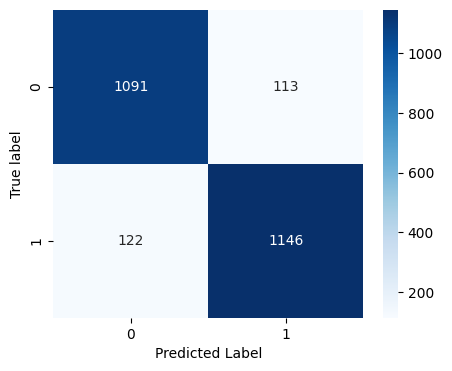

In [170]:
preds_binary = np.where(preds > eer, 1, 0)
conf = confusion_matrix(Y_test, preds_binary)
# Compare the predictions with the actual values
correct_preds = np.sum(preds_binary == Y_test)
wrong_preds = len(Y_test) - correct_preds

print(f"Number of correct predictions: {correct_preds}")
print(f"Number of wrong predictions: {wrong_preds}")
print(f"Accuracy: {accuracy_score(Y_test, preds_binary)}")

plt.figure(figsize=(5,4))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap=plt.cm.Blues)
ax.set(xlabel='Predicted Label',
       ylabel='True label')